In [1]:
#Import 
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from scipy.linalg import norm


In [2]:
from SGD_GD import stoch_grad
from L2regpb import L2regLS
from utils import generate_pb_parameters
from S2GD import S2GD
from SAGA import SAGA
from plot_iterations import plot_with_nb_gradients, plot_with_time

# Synthetic Least Squares

In [3]:
d = int(50)
n = int(25000)
idx = np.arange(d)
lbda = 1. / n ** (0.5)
#lbda = 0
kappa = 1e3

np.random.seed(1)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

A, y = generate_pb_parameters(x_model_truth, n, d, kappa,lbda, std=0, corr=0.7)
ylog = np.sign(y) # Taking the logarithm for binary classification
yone = np.copy(ylog)
yone[ylog==-1] = 0 
x0 = np.random.randn(d)
pbL2reg = L2regLS(A,y,lbda,'l2')

print(pbL2reg.fun(x_model_truth))

0.017444404644904078


In [4]:
x_sgd,obj_val_sgd,_,nb_comp_grad_sgd, times1 = stoch_grad(x0=x0,problem=pbL2reg,xtarget=x_model_truth,stepchoice=0,step0=3e-3, n_iter=400000,nb=1,with_replace=False,verbose=True,fast=True)

Stochastic Gradient, batch size= 1 / 25000
  iter   |   fval   |  normit 
       0 | 9.76e+01 | 7.87e+00
   25000 | 3.97e-02 | 1.65e+00
   50000 | 2.73e-02 | 1.44e+00
   75000 | 2.46e-02 | 1.31e+00
  100000 | 2.31e-02 | 1.19e+00
  125000 | 2.21e-02 | 1.08e+00
  150000 | 2.12e-02 | 9.87e-01
  175000 | 2.06e-02 | 9.01e-01
  200000 | 2.00e-02 | 8.24e-01
  225000 | 1.96e-02 | 7.54e-01
  250000 | 1.92e-02 | 6.91e-01
  275000 | 1.89e-02 | 6.34e-01
  300000 | 1.86e-02 | 5.83e-01
  325000 | 1.84e-02 | 5.35e-01
  350000 | 1.83e-02 | 4.93e-01
  375000 | 1.81e-02 | 4.54e-01
  400000 | 1.80e-02 | 4.18e-01


In [5]:
x_s2gd,obj_val_s2gd,_,nb_comp_grad_s2gd, times2 = S2GD(x0=x0,problem=pbL2reg,xtarget=x_model_truth,h=-1,m=10,nu=pbL2reg.cvxval(),eps_tol=1e-8,n_iter=20,plus=False)

h= 0.0012971039570516807 m= 23467 n_iter= 19
S2GD, n=25000. Exepcted number of inner loop at each iteration: 12114 in [11734,23467)
  iter   |   fval   |  normit  |    t    
       0 | 9.76e+01 | 7.87e+00 | 0.00e+00
       1 | 1.17e+01 | 3.24e+00 | 5.52e+03
       2 | 6.64e-01 | 1.61e+00 | 1.15e+04
       3 | 8.35e-02 | 1.15e+00 | 2.26e+04
       4 | 2.57e-02 | 1.12e+00 | 1.26e+03
       5 | 2.10e-02 | 9.26e-01 | 1.82e+04
       6 | 2.05e-02 | 9.02e-01 | 2.69e+03
       7 | 1.99e-02 | 8.12e-01 | 1.07e+04
       8 | 1.91e-02 | 6.85e-01 | 1.78e+04
       9 | 1.90e-02 | 6.55e-01 | 4.64e+03
      10 | 1.86e-02 | 5.70e-01 | 1.49e+04
      11 | 1.82e-02 | 4.70e-01 | 2.10e+04
      12 | 1.81e-02 | 4.38e-01 | 7.84e+03
      13 | 1.79e-02 | 3.95e-01 | 1.16e+04
      14 | 1.78e-02 | 3.44e-01 | 1.58e+04
      15 | 1.78e-02 | 3.30e-01 | 4.90e+03
      16 | 1.77e-02 | 3.05e-01 | 8.94e+03
      17 | 1.77e-02 | 3.01e-01 | 1.63e+03
      18 | 1.77e-02 | 2.84e-01 | 6.95e+03
      19 | 1.76e-02 | 2.70e-

In [13]:
#=====Parameters for plots ======
nb_gradients = [nb_comp_grad_s2gd, nb_comp_grad_sgd]
obj_functions = [obj_val_s2gd, obj_val_sgd]
name_of_models = ['S2GD', 'SGD']
list_times = [times2, times1]

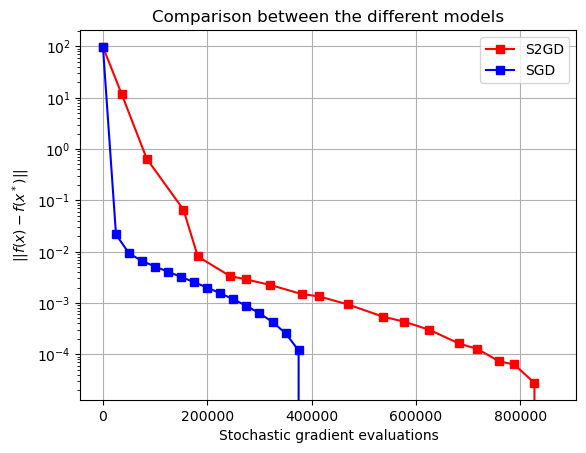

In [14]:
plot_with_nb_gradients(nb_gradients, obj_functions, name_of_models)

20
17


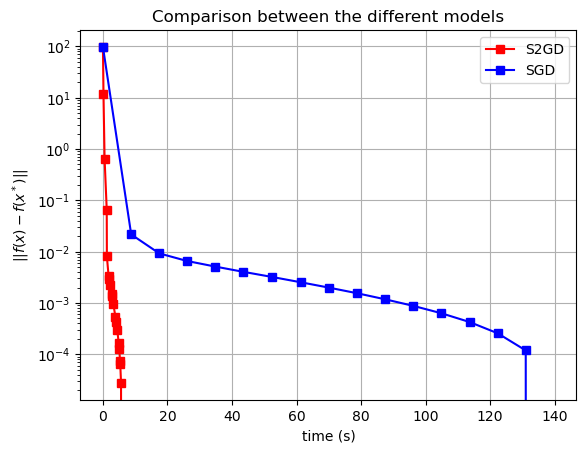

In [18]:
plot_with_time(list_times, obj_functions, name_of_models)

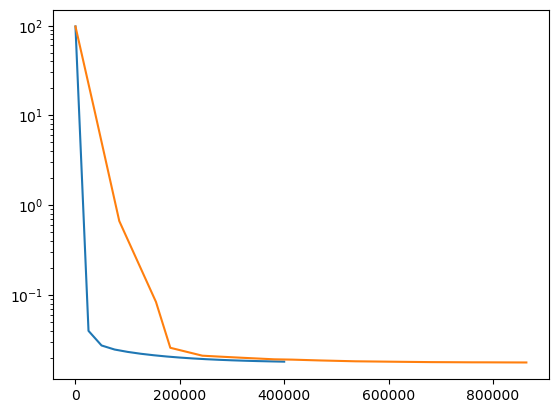

In [11]:
plt.semilogy(nb_comp_grad_sgd,obj_val_sgd)
plt.semilogy(nb_comp_grad_s2gd,obj_val_s2gd)

# MNIST logistic

In [7]:
def load_mnist_5_8():
    # Charger les datasets MNIST pour l'entraînement et le test
    mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
    mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
    
    # Filtrer les classes 5 et 8 pour l'entraînement
    train_indices_5_8 = np.where((mnist_train.targets == 5) | (mnist_train.targets == 8))[0]
    train_data_5_8 = mnist_train.data[train_indices_5_8]
    train_labels_5_8 = mnist_train.targets[train_indices_5_8]
    
    # Filtrer les classes 5 et 8 pour le test
    test_indices_5_8 = np.where((mnist_test.targets == 5) | (mnist_test.targets == 8))[0]
    test_data_5_8 = mnist_test.data[test_indices_5_8]
    test_labels_5_8 = mnist_test.targets[test_indices_5_8]
    
    # Convertir les labels en {0, 1} (5 -> -1, 8 -> 1)
    train_labels_5_8[train_labels_5_8 == 5] = -1
    train_labels_5_8[train_labels_5_8 == 8] = 1
    test_labels_5_8[test_labels_5_8 == 5] = -1
    test_labels_5_8[test_labels_5_8 == 8] = 1
    

    # Aplatir les images en vecteurs (28x28 -> 784) et normaliser
    train_A = train_data_5_8.view(train_data_5_8.size(0), -1).float() / 255.0
    test_A = test_data_5_8.view(test_data_5_8.size(0), -1).float() / 255.0
    # train_A = train_data_5_8.view(train_data_5_8.size(0), -1).float() 
    # test_A = test_data_5_8.view(test_data_5_8.size(0), -1).float() 

    # Ajouter une colonne de biais à chaque matrice
    # train_bias = torch.ones((train_A.size(0), 1))
    # test_bias = torch.ones((test_A.size(0), 1))
    # train_A = torch.cat((train_A, train_bias), dim=1)  # train_A de dimension (n_train, 785)
    # test_A = torch.cat((test_A, test_bias), dim=1)    # test_A de dimension (n_test, 785)
    
    # Retourner les données
    return train_A.numpy(), train_labels_5_8.numpy(), test_A.numpy(), test_labels_5_8.numpy()

# Charger les données
train_A, train_y, test_A, test_y = load_mnist_5_8()

In [8]:
lbda = 0.05
d = train_A.shape[1]
pblogreg = L2regLS(train_A,train_y,lbda,loss='logistic11')
pblogreg.kappa_val

239.1598365443281

#### Run GD for a lot of epochs to have an estimate solution

In [9]:
x_gd,obj_val_gd,_= stoch_grad(x0=x0,problem=pblogreg,xtarget=np.zeros(d),stepchoice=0,step0=1, n_iter=5000,nb=pblogreg.n,with_replace=False,verbose=True)
f_star = obj_val_gd[-1]
x_star = x_gd

ValueError: shapes (11272,784) and (50,) not aligned: 784 (dim 1) != 50 (dim 0)

In [ ]:
x0 = np.random.randn(d)
x_sgd,obj_val_sgd,_,nb_comp_grad_sgd = stoch_grad(x0=x0,problem=pblogreg,xtarget=x_star,stepchoice=0,step0=1e-2, n_iter=50000,nb=1,with_replace=False,verbose=True,fast=True)

In [ ]:
x_s2gd,obj_val_s2gd,_,nb_comp_grad_s2gd = S2GD(x0=x0,problem=pblogreg,xtarget=x_star,h=-1,m=10,nu=pblogreg.cvxval(),eps_tol=1e-15,n_iter=30,plus=True)

In [ ]:
x_saga,obj_val_saga,_,nb_comp_grad_saga = SAGA(x0,pblogreg,x_star,-1,1e-10,50000,fast=True)

In [ ]:
plt.semilogy(nb_comp_grad_sgd,obj_val_sgd-f_star)
plt.semilogy(nb_comp_grad_s2gd,obj_val_s2gd-f_star)
plt.semilogy(nb_comp_grad_saga,obj_val_saga-f_star)

In [ ]:
error_s2gd = 0
error_sgd = 0
for  i in range(len(test_y)):
    if np.sign(np.dot(test_A,x_s2gd))[i] != test_y[i] : 
        error_s2gd += 1
    if np.sign(np.dot(test_A,x_sgd))[i] != test_y[i] : 
        error_sgd += 1
error_s2gd /= len(test_y)
error_sgd /= len(test_y)
error_s2gd, error_sgd